# Introduction

Here I'm exploring the transition from the static async state to the active phase wave state. I'm plotting various quantities, and seeing where they bifurcate. This is to evaulate my approximation $K_c = -1.2 J$ -- equation (18) in the paper https://www.nature.com/articles/s41467-017-01190-3.

Specifically, I'm looking at the order parameter S = max(S^+, S^-), which should bifurcate from zero when transition from the static async state (see paper for why). Also, since the swarmalators are stationary in the static async state, it should bifurcate from zero when S does too. Lastly, the radii of the support of the spatial densities of the swarmaltors should change as the S.A. static is left. 


### Things to try in future

Adding noise (in both the $\dot{\theta}$ and $\dot{\vec{x}}$) equations should stabilize the async state. I should (a) run numerical experiments with noise added in, and (b) redo the analysis. Regarding (b), this should be easy to do when phase noise (noise in the $\dot{\theta}$ equation) is added, since the the spatial velocity of the swarmalators should still be zero in this case, and so the density is still $\rho_{async} = \frac{1}{ 4 \pi^2} g(r)$ for $r < R_{async}$ (see equations (5) and (6) in the paper).

If spatial noise is added, then $\rho_{async} \neq \frac{1}{ 4 \pi^2} g(r)$, and so the stability analysis is much harder.


### Preamble

In [15]:
import numpy as np
import swarmalators_funcs as f
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time
%matplotlib inline
from IPython.display import clear_output, display, HTML 

#this is for an interact-like function later -- comment out if the python complains
#from IPython.html.widgets import interact, interactive 

# Using global variables here (tut tut), to make reading in the data later easier
a, dt, T, n, L  = 1, 0.5, 500, 500, 1 

# Function that will be passed to the multi-processor
def func(pars):

    #Define parameters
    #a, dt, T, n, L  = 1, 0.5, 500, 100, 1   #I decided to use global variables
    t = [dt*i for i in range(int(T/dt))]
    np.random.seed(0)
    x0 = np.random.uniform(-L,L,n);y0=np.random.uniform(-L,L,n);theta0 = np.random.uniform(-np.pi,np.pi,n)
    J, K, omega = pars[0], pars[1], np.zeros(n);

    
    #Do simulation
    tic = time.clock()
    z0 = np.array([x0,y0,theta0])
    z0 = z0.flatten()
    sols = odeint(f.rhs_unit_vector, z0, t, args=(J,K,n,omega))
    x, y, theta = f.unpack(sols,n)
    r, phi = f.cart_to_polar(x,y)
    gamma = f.find_gamma(phi)
    v = f.find_vel_t(x,y,theta,dt)
    transient_index = int(0.9*x.shape[0])
    v_mean = np.mean([np.mean(v[t,:]) for t in range(transient_index,v.shape[0])])
    S_plus = np.mean(np.abs(f.find_W_plus(x,y,theta))[transient_index:-1])
    S_minus = np.mean(np.abs(f.find_W_minus(x,y,theta))[transient_index:-1])
    R_max = np.mean([np.max( np.sqrt(x[t,:]**2 + y[t,:]**2) ) for t in range(x.shape[0])][transient_index:-1])
    R_min = np.mean([np.min( np.sqrt(x[t,:]**2 + y[t,:]**2) ) for t in range(x.shape[0])][transient_index:-1])

    
    #Save to file
    string =  'K_' + str(K) + '_J_' + str(J) + '_N_' + str(n) + '_T_' + str(T) + '_dt_' + str(dt) +  '.csv'
    with open('data/S_plus_' + string, 'wb') as f1:
        np.savetxt(f1, [S_plus])
    with open('data/S_minus_' + string, 'wb') as f2:
        np.savetxt(f2, [S_minus])
    with open('data/v_mean_' + string, 'wb') as f6:
        np.savetxt(f6, [v_mean])
    with open('data/gamma_' + string, 'wb') as f65:
        np.savetxt(f65, np.array([gamma]))
    with open('data/R_max_' + string, 'wb') as f7:
        np.savetxt(f7, [R_max])
    with open('data/R_min_' + string, 'wb') as f8:
        np.savetxt(f8, [R_min])
    toc = time.clock()
    print '(J,K) = ' + str((J,K)) + ' took ' + str((toc-tic)/60.0**2) + ' hours'
    return v_mean

### Do simulation and record data 

1. Can ignore the divide by zero error (I account for this in the function rhs_unit_vector) -- does anyone know a way to silence python's error messages?

2. Note, it's not a good idea to stop simulation as its running, the multiprocessor doesn't respond well to it. In   particular, lots of thread get stuck (you can see these using the 'top' command at the terminal), and I have to kill them manually. The way I kill them is using "pkill -f python", but unfortunately this kills the kernel running the ipython notebook, so I have to restart that too!

In [16]:
from multiprocessing import Pool
num_of_processes = 6
#Ks = np.array([-i*0.1 for i in range(51)])
#Js = np.array([0.2, 0.4, 0.6, 0.8, 1.0])
Ks = np.array([-i*0.1 for i in range(11)])
Js = np.array([0.2, 0.7])

for J in Js:
    #Set up parameters in right foramt
    temp = np.full(len(Ks),J)
    pars = zip(temp,Ks)
    
    #Do sims
    workers = Pool(num_of_processes)  #create the workers
    workers.map(func, pars)           #set them working!
    workers.close()                   #close them once they're done
    workers.join()

swarmalators_funcs.py:30: RuntimeWarning: divide by zero encountered in divide
  inverse_dist_sq = np.nan_to_num(1.0/((xd)**2 + (yd)**2))
swarmalators_funcs.py:30: RuntimeWarning: divide by zero encountered in divide
  inverse_dist_sq = np.nan_to_num(1.0/((xd)**2 + (yd)**2))
swarmalators_funcs.py:30: RuntimeWarning: divide by zero encountered in divide
  inverse_dist_sq = np.nan_to_num(1.0/((xd)**2 + (yd)**2))
swarmalators_funcs.py:30: RuntimeWarning: divide by zero encountered in divide
  inverse_dist_sq = np.nan_to_num(1.0/((xd)**2 + (yd)**2))
swarmalators_funcs.py:30: RuntimeWarning: divide by zero encountered in divide
  inverse_dist_sq = np.nan_to_num(1.0/((xd)**2 + (yd)**2))
swarmalators_funcs.py:30: RuntimeWarning: divide by zero encountered in divide
  inverse_dist_sq = np.nan_to_num(1.0/((xd)**2 + (yd)**2))


(J,K) = (0.20000000000000001, -0.20000000000000001) took 0.0504407144444 hours
(J,K) = (0.20000000000000001, -0.60000000000000009) took 0.0471587166667 hours
(J,K) = (0.20000000000000001, -0.5) took 0.1127833675 hours
(J,K) = (0.20000000000000001, -0.70000000000000007) took 0.0445652644444 hours
(J,K) = (0.20000000000000001, -0.30000000000000004) took 0.146383248056 hours
(J,K) = (0.20000000000000001, -0.80000000000000004) took 0.0469103683333 hours
(J,K) = (0.20000000000000001, 0.0) took 0.180501208056 hours
(J,K) = (0.20000000000000001, -0.90000000000000002) took 0.0398722061111 hours
(J,K) = (0.20000000000000001, -0.40000000000000002) took 0.232963881389 hours
(J,K) = (0.20000000000000001, -0.10000000000000001) took 0.315886972222 hours
(J,K) = (0.20000000000000001, -1.0) took 0.200775676389 hours


swarmalators_funcs.py:30: RuntimeWarning: divide by zero encountered in divide
  inverse_dist_sq = np.nan_to_num(1.0/((xd)**2 + (yd)**2))
swarmalators_funcs.py:30: RuntimeWarning: divide by zero encountered in divide
  inverse_dist_sq = np.nan_to_num(1.0/((xd)**2 + (yd)**2))
swarmalators_funcs.py:30: RuntimeWarning: divide by zero encountered in divide
  inverse_dist_sq = np.nan_to_num(1.0/((xd)**2 + (yd)**2))
swarmalators_funcs.py:30: RuntimeWarning: divide by zero encountered in divide
  inverse_dist_sq = np.nan_to_num(1.0/((xd)**2 + (yd)**2))
swarmalators_funcs.py:30: RuntimeWarning: divide by zero encountered in divide
  inverse_dist_sq = np.nan_to_num(1.0/((xd)**2 + (yd)**2))
swarmalators_funcs.py:30: RuntimeWarning: divide by zero encountered in divide
  inverse_dist_sq = np.nan_to_num(1.0/((xd)**2 + (yd)**2))


(J,K) = (0.69999999999999996, 0.0) took 0.1842572125 hours
(J,K) = (0.69999999999999996, -0.10000000000000001) took 0.531331865 hours
(J,K) = (0.69999999999999996, -0.20000000000000001) took 0.640160951944 hours
(J,K) = (0.69999999999999996, -0.80000000000000004) took 0.063416185 hours
(J,K) = (0.69999999999999996, -0.90000000000000002) took 0.0922287666667 hours
(J,K) = (0.69999999999999996, -1.0) took 0.0502588327778 hours
(J,K) = (0.69999999999999996, -0.30000000000000004) took 1.20677232667 hours
(J,K) = (0.69999999999999996, -0.70000000000000007) took 1.5383091325 hours
(J,K) = (0.69999999999999996, -0.40000000000000002) took 2.229601805 hours
(J,K) = (0.69999999999999996, -0.60000000000000009) took 2.47286405556 hours
(J,K) = (0.69999999999999996, -0.5) took 2.72152252944 hours


### Read in and plot data

1. Make sure you've set T large enough, so that transients have died. I found T ~ 500 to work. Sometimes had to go to T = 1000.
2. Also, dt = 0.5 seems to be OK (but obviously need to check smaller values to be sure)

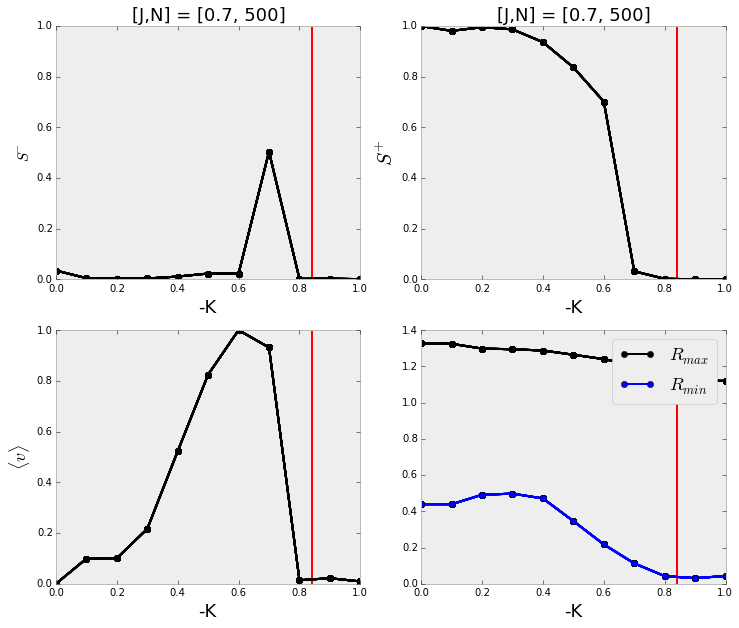

In [19]:
# Which value of J do I wish to load in 
#J = 0.2
J = 0.7

#These will hold various values
Sp, Sm, vm, Rmax, Rmin = [], [], [], [], []

# Read in the data
for K in Ks:
    string =  'K_' + str(K) + '_J_' + str(J) + '_N_' + str(n) + '_T_' + str(T) + '_dt_' + str(dt) +  '.csv'
    Sp1 = np.loadtxt('data/S_plus_' + string)
    Sm1 = np.loadtxt('data/S_minus_' + string)
    v_mean = np.loadtxt('data/v_mean_' + string)
    R_max1 = np.loadtxt('data/R_max_' + string)
    R_min1 = np.loadtxt('data/R_min_' + string)

    Sp.append(Sp1);Sm.append(Sm1);vm.append(v_mean);Rmax.append(R_max1);Rmin.append(R_min1)


#Convert to numpy arrays so I can read them.
Sp,Sp,vm,Rmax,Rmin = np.array(Sp), np.array(Sp), np.array(vm), np.array(Rmax), np.array(Rmin)    
#Plot
fig = plt.figure(figsize=(12,10))
plt.subplot(221)
plt.title('[J,N] = ' + str([J,n]), fontsize=18)
for i in range(len(Sm)):
    plt.subplot(221)
    plt.plot(-Ks,Sm,'ko-')
    plt.ylim([0,1.0]);
    plt.xlabel('-K',fontsize=18);plt.ylabel('$S^-$', fontsize=15)
    plt.vlines(1.2*J,0,1,color='red')
plt.subplot(222)
plt.title('[J,N] = ' + str([J,n]), fontsize=18)
for i in range(len(Sp)):
    plt.plot(-Ks,Sp,'ko-')
    plt.ylim([0,1.0]);
    plt.xlabel('-K',fontsize=18);plt.ylabel('$S^+$',fontsize=20)
    plt.vlines(1.2*J,0,1,color='red')
plt.subplot(223)
for i in range(len(vm)):
    plt.plot(-Ks,vm / np.max(vm),'ko-')
    plt.xlabel('-K',fontsize=18);plt.ylabel('$ \\langle v \\rangle$', fontsize=18)
    plt.vlines(1.2*J,0,1,color='red')
plt.subplot(224)
for i in range(len(Rmax)):
    plt.plot(-Ks,Rmax,'ko-');plt.plot(-Ks,Rmin,'bo-')
    plt.xlabel('-K',fontsize=18);plt.legend(['$R_{max}$', '$R_{min}$'], fontsize=18)
    plt.vlines(1.2*J,0,np.max(Rmax),color='red')

$J = 0.7$ works well, but $J = 0.2$, not so much.